In [1]:
# simple CNN example
# Multiclass image scene classification
# data sources: 
# https://www.kaggle.com/puneet6060/intel-image-classification/version/2
# upzip and upload to your Gdrive under directoris "intel_scenes_seg_train" and "intel_scenes_seg_test, intel_scenes_seg_pred"
# this is a large dataset .. It will take some time (+60 minutes) to upload everything...

# example usage
# https://www.kaggle.com/pranjalsoni17/natural-scene-classification

import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#set the data paths
home = '/content/drive/MyDrive/'
start = '/content/drive/MyDrive/ART/machinelearning/'
datapath = start + 'data/'

In [4]:
#train and test data directory
data_dir = datapath + "intel_scenes_seg_train/"
test_data_dir = datapath + "intel_scenes_seg_test/"
pred_data_dir = datapath + "intel_scenes_seg_pred/"

#load the train and test data, and resize the images to 150x150 pixels
xsize = 150
ysize = 150
dataset = ImageFolder(data_dir, transform = transforms.Compose([transforms.Resize((xsize, ysize)), transforms.ToTensor()]))
test_dataset = ImageFolder(test_data_dir, transforms.Compose([transforms.Resize((xsize, ysize)), transforms.ToTensor()]))

In [5]:
# How much data do we have?
print(f"Images in tarining data : {len(dataset)}")
print(f"Images in test data : {len(test_dataset)}")

Images in tarining data : 14034
Images in test data : 3000


In [6]:
#check the size and dimension of the images
img, label = dataset[0]
print(img.shape,label)

torch.Size([3, 150, 150]) 0


In [7]:
#check the labels
print("Here are the names of the classes : \n", dataset.classes)

Here are the names of the classes : 
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [8]:
# Create a display function
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

Label : buildings


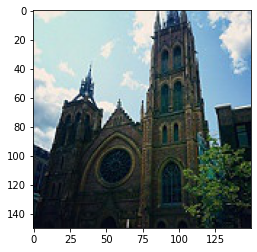

In [11]:
# Display the first image in the dataset
display_img(*dataset[5])

In [12]:
# Load the train and validation into batches
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 128
val_size = 2000
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

Length of Train Data : 12034
Length of Validation Data : 2000


In [13]:
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
# Visualize a data batch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


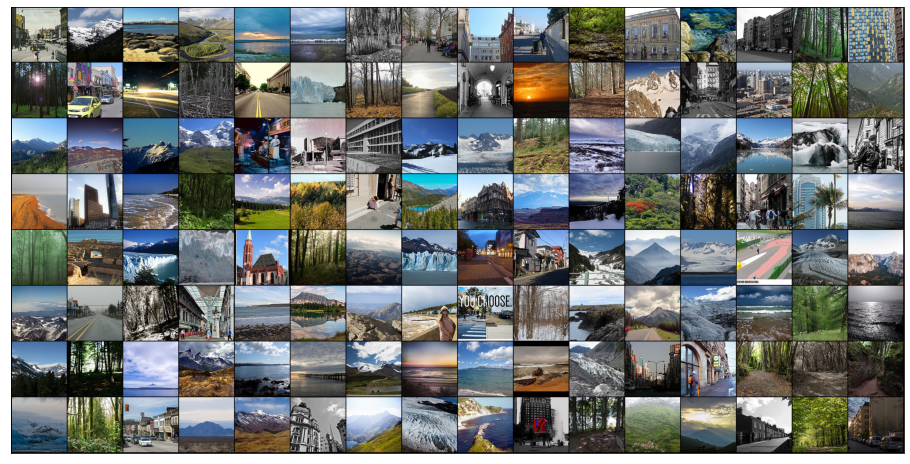

In [15]:
show_batch(train_dl)

In [16]:
# Define training and validation functions

import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))


In [17]:
# Create a neural network for this dataset

class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [18]:
# Define fit, evaluation and accuracy methods

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return (history)

In [19]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [20]:
# Check the device... ensure it says 'cuda'.. if not change the runtime type
device = get_default_device()
print(device)

cuda


In [21]:
# Load the model to the device
model = to_device(NaturalSceneClassification(),device)

In [22]:
# Load the into GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

NaturalSceneClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Li

In [ ]:
# Initial evaluation of the model ... takes ...[in class]  30min +
# validation accuracy (val_acc) is very low ... the model is not trained yet...
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Train the network - 30 epochs will take some 75 minutes !
num_epochs = 3
opt_func = torch.optim.Adam
lr = 0.001

# Fit the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
print("Training complete")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.2003, val_loss: 0.9764, val_acc: 0.5998
Epoch [1], train_loss: 0.8759, val_loss: 1.0966, val_acc: 0.5682
Epoch [2], train_loss: 0.7697, val_loss: 0.6440, val_acc: 0.7580
Epoch [3], train_loss: 0.5958, val_loss: 0.6747, val_acc: 0.7509
Epoch [4], train_loss: 0.4769, val_loss: 0.6822, val_acc: 0.7683
Epoch [5], train_loss: 0.3726, val_loss: 0.6196, val_acc: 0.8128
Epoch [6], train_loss: 0.2566, val_loss: 0.7657, val_acc: 0.7999
Epoch [7], train_loss: 0.1730, val_loss: 0.9021, val_acc: 0.7995
Epoch [8], train_loss: 0.1128, val_loss: 1.0702, val_acc: 0.7968
Epoch [9], train_loss: 0.0942, val_loss: 1.0430, val_acc: 0.7954
Epoch [10], train_loss: 0.0707, val_loss: 1.2536, val_acc: 0.7842
Epoch [11], train_loss: 0.0798, val_loss: 1.1486, val_acc: 0.7749
Epoch [12], train_loss: 0.0433, val_loss: 1.3036, val_acc: 0.7921
Epoch [13], train_loss: 0.0758, val_loss: 1.4286, val_acc: 0.7658
Epoch [14], train_loss: 0.1185, val_loss: 1.2553, val_acc: 0.7943
Epoch [15], train_lo

In [ ]:
# Plot the results
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

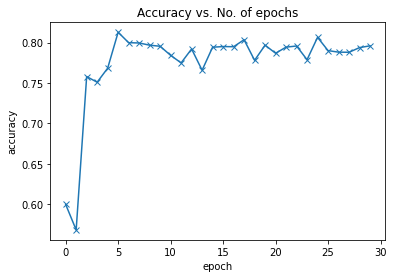

In [ ]:
plot_accuracies(history)

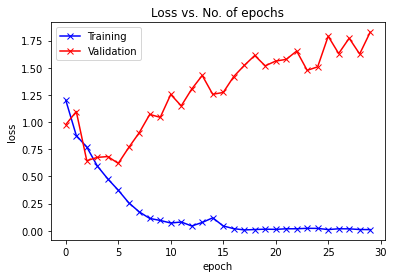

In [ ]:
plot_losses(history)

In [ ]:
# Apply the model on test dataset ... this step takes about 8 minutes 
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
print(result)

{'val_loss': 1.799628734588623, 'val_acc': 0.79445481300354}


In [ ]:
# Save the model
torch.save(model.state_dict(), datapath + 'natural-scene-classification.pth')

In [ ]:
# Define a prediction function
def predict_img_class(img, model):
    """ Predict the class of image and Return Predicted Class"""
    img = to_device(img.unsqueeze(0), device)
    prediction =  model(img)
    _, preds = torch.max(prediction, dim = 1)
    return (dataset.classes[preds[0].item()])

Predicted Class : mountain


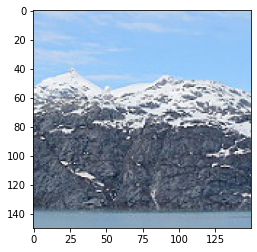

In [ ]:
from PIL import Image

# Open image file
sample = "119.jpg"
img = Image.open(pred_data_dir + sample)

# Convert image to tensor
img = transforms.ToTensor()(img)

# Show image
plt.imshow(img.permute(1,2,0))

# Predict image label
print(f"Predicted Class : {predict_img_class(img, model)}")